In [ ]:
import os
import glob

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmaps as gvcmaps
import geocat.viz.util as gvutil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter

In [2]:
path = "/glade/derecho/scratch/malbright/era5_monthly/"
ds = xr.open_mfdataset(
    path + "e5.moda.fc.sfc.meanflux.235_055_mtpr.ll025sc.*.nc"
).load()

ds["MTPR"] = ds.MTPR * 86400


def convert_longitude(lon_array):
    return np.where(lon_array > 180, lon_array - 360, lon_array)


# Convert the longitude values
converted_lon = convert_longitude(ds.longitude.values)

# Create a new coordinate with converted longitudes
ds = ds.assign_coords(lon=("lon", converted_lon))

# Sort the DataArray by longitude
ds = ds.sortby("lon")

months = [6, 7, 8, 9]
subset = ds.sel(time=ds["time"].dt.month.isin(months))

avg = subset.mean(dim="time")
total_avg = ds.mean(dim="time")

pct = ((avg.MTPR * 122) / (total_avg.MTPR * 365)) * 100

In [3]:
def _monsoon_threshold(da):
    """Return a 60% threshold compatible with percent or fraction inputs."""
    try:
        mx = float(da.max().values)  # robust for xarray
    except Exception:
        mx = float(da.max())
    return 60.0 if mx > 1.5 else 0.60


def add_monsoon_contours(
    ax,
    da_plio,
    *,
    color="#D62728",  # crimson (Tableau red)
    lw=1.0,
    dash_pattern=(6, 4),
):
    """
    Draws monsoon extent (>=60%) on `ax`.
    Expects DataArray with lat/lon coords; works with PlateCarree axes.
    """

    thr = _monsoon_threshold(da_plio)

    if "lat" in da_plio.dims and "lon" in da_plio.dims:
        cs_pl = da_plio.plot.contour(
            ax=ax,
            x="lon",
            y="lat",
            levels=[thr],
            colors=[color],
            linewidths=lw,
            linestyles="solid",
            transform=ccrs.PlateCarree(),
            add_colorbar=False,
            zorder=6,
        )
    else:
        cs_pl = da_plio.plot.contour(
            ax=ax,
            levels=[thr],
            colors=[color],
            linewidths=lw,
            linestyles="solid",
            transform=ccrs.PlateCarree(),
            add_colorbar=False,
            zorder=6,
        )

    return cs_pl

In [ ]:
IMERG_ROOT = "/glade/campaign/collections/gdex/data/d736000/gpm_3imergm_v07"


def open_imerg_monthly(fname):
    """Open a single IMERG monthly HDF5 file as a DataArray with a time dim."""
    ds_imerg = xr.open_dataset(
        fname,
        engine="h5netcdf",
        group="Grid",
    ).sel(lon=slice(-115, -90), lat=slice(10, 35))

    # Choose variable name
    if "precipitationCal" in ds_imerg:
        da = ds_imerg["precipitationCal"]
    elif "precipitation" in ds_imerg:
        da = ds_imerg["precipitation"]
    else:
        raise KeyError(f"No precipitation variable found in {fname}")

    # Parse date from filename (e.g., 3B-MO.MS.MRG.3IMERG.20010701-S000000-...)
    base = os.path.basename(fname)
    parts = base.split(".")
    # parts[4] looks like '20010701-S000000-E235959'
    date_str = parts[4].split("-")[0]
    time = pd.to_datetime(date_str, format="%Y%m%d")

    # Ensure we have a time dimension
    if "time" not in da.dims:
        da = da.expand_dims(time=[time])
    else:
        # Overwrite whatever weird scalar time is there
        da = da.assign_coords(time=[time])

    # Convert mm/hr to mm/day (if that's the unit)
    # Comment this out if the file is already mm/day.
    da = da * 24.0
    da.attrs["units"] = "mm/day"

    return da


years = range(2001, 2025)
all_months = []

for year in years:
    year_dir = os.path.join(IMERG_ROOT, f"{year}")
    files = sorted(glob.glob(os.path.join(year_dir, "*.HDF5")))
    if not files:
        print(f"Warning: no files found for {year}")
        continue

    for fname in files:
        da = open_imerg_monthly(fname)
        all_months.append(da)

# Concatenate along time
imerg_all = xr.concat(all_months, dim="time")

# Just in case: sort by time
imerg_all = imerg_all.sortby("time")

# Just to be extra explicit on the time slice:
sel = imerg_all.sel(time=slice("2001-01-01", "2024-12-31"))

# JJAS (Jun–Sep) climatology
jjas = sel.where(sel["time"].dt.month.isin([6, 7, 8, 9]), drop=True).mean("time")

# Annual climatology (all months)
annual = sel.mean("time")

ratio = ((jjas * 122) / (annual * 365)) * 100

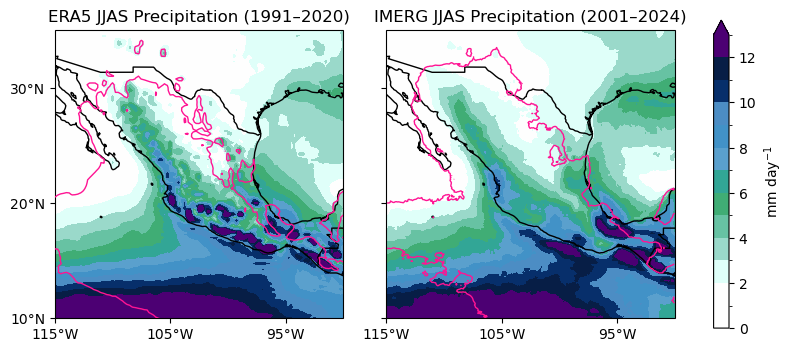

In [ ]:
# Specify projection for maps
proj = ccrs.PlateCarree()

# Generate figure (set its size (width, height) in inches)
fig = plt.figure(figsize=(10, 5))
grid = fig.add_gridspec(
    ncols=2,
    nrows=1,
    wspace=0.15,
    hspace=0.05,
)

# Left panel: ERA5
ax1 = fig.add_subplot(grid[0, 0], projection=proj)
ax1.add_feature(cfeature.COASTLINE, zorder=3)
ax1.add_feature(cfeature.BORDERS)

gvutil.set_axes_limits_and_ticks(
    ax1,
    xlim=(-115, -90),
    ylim=(10, 35),
    xticks=np.linspace(-130, -90, 13),
    yticks=np.linspace(15, 50, 7),
)

ax1.xaxis.set_major_formatter(LongitudeFormatter())
ax1.yaxis.set_major_formatter(LatitudeFormatter())

# Colormap and levels
newcmp = gvcmaps.precip4_11lev
levels = np.arange(0, 14, 1)

kwargs = dict(
    levels=levels,
    xticks=np.arange(-115, -90, 10),
    yticks=np.arange(10, 35, 10),
    add_colorbar=False,
    transform=ccrs.PlateCarree(),
)

fillplot_era5 = avg.MTPR.plot.contourf(
    ax=ax1,
    cmap=newcmp,
    **kwargs,
)

add_monsoon_contours(ax1, pct, color="deeppink")

gvutil.set_titles_and_labels(
    ax1,
    xlabel="",
    ylabel="",
)
ax1.set_title("ERA5 JJAS Precipitation (1991–2020)", fontsize=12, loc="center")

# Right panel: IMERG
ax2 = fig.add_subplot(grid[0, 1], projection=proj)
ax2.add_feature(cfeature.COASTLINE, zorder=3)
ax2.add_feature(cfeature.BORDERS)

gvutil.set_axes_limits_and_ticks(
    ax2,
    xlim=(-115, -90),
    ylim=(10, 35),
    xticks=np.linspace(-130, -90, 13),
    yticks=np.linspace(15, 50, 7),
)

ax2.xaxis.set_major_formatter(LongitudeFormatter())
ax2.yaxis.set_tick_params(labelleft=False)

file_imerg = jjas

fillplot_imerg = file_imerg.plot.contourf(
    ax=ax2,
    x="lon",
    y="lat",
    cmap=newcmp,
    **kwargs,
)

add_monsoon_contours(ax2, ratio, color="deeppink")

gvutil.set_titles_and_labels(
    ax2,
    xlabel="",
    ylabel="",
)
ax2.set_title("IMERG JJAS Precipitation (2001–2024)", fontsize=12, loc="center")

# Single colorbar for the whole figure
cbar_diff = fig.colorbar(fillplot_imerg, ax=[ax1, ax2], shrink=0.8, location="right")
cbar_diff.ax.set_ylabel("mm day$^{-1}$")

# plt.show()
plt.savefig("figures/supplement_era5_imerg_monsoon_panel.png", dpi=150, bbox_inches="tight")